Colab Preparation, comment the following if you are running on local.

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')
!ls
os.chdir('/content/drive/MyDrive/2022S1/90042nlp/proj')
!ls

Mounted at /content/drive
drive  sample_data
 bactch8epoch10RoGrucell.dat   GPU_TokenSeq_Roberta_Gru.ipynb
 batch16epoch10grucell.dat     grucell_32.dat
 batch8epoch10ROGRU.dat        gru.ipynb
 batch8epoch4BERT.dat	       logs
 batch8epoch4ROGRU.dat	       maxpool_gru.dat
 batch8epoch4RoGruSeq.dat      param
 BERT_FC.ipynb		       pickleData.ipynb
 covid_result.csv	       project-data
 evidence512.pt		       project.pdf
 evidence_highdrop_12.pt       proj.ipynb
 evidence_highL2_15.pt	       report.gdoc
 evidence.ipynb		       roberta_grucell.ipynb
 evidence+lastfour.ipynb       roberta_pretrained
 evidence+lastfour.pt	       ro_mean_four_gru.dat
 glove			      'RumourCLS and Sentiment.ipynb'
 GPU_BERT.ipynb		       sentenceTransformer.ipynb
 GPU_Roberta_cnn.ipynb	       seqgru.pt
 GPU_Roberta_gru.ipynb	       simplegru+seqgru+bi.ipynb
 GPU_Roberta_gru_moxue.ipynb   submissioncsv
 GPU_SBert_Roberta_Gru.ipynb   test_text.csv


In [ ]:
!pip install torchvision transformers
!pip install torch==1.11.0

# Data Preprocessing

Import and download related lib for text preprocessing.

In [ ]:
import nltk
nltk.download("words") 
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Preprocessing contains:
1. lower case
2. remove retweet format, hashtag, emoji
3. substitute @ and url to @user and http (especially for roberta)
4. tokenize and remove stopwords
5. lemmatize tokens\
But we just use 3, because more cleaning data may result in bad performance.

In [ ]:
import re

stopwords = set(stopwords.words("english"))

# remove http and symbols
# reg_map = {
#     re.compile("rt [@0-9a-z_]{0,10}:"),
#     re.compile("#[0-9a-z]+"),
# }
reg_http = re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")
reg_user = re.compile("@[0-9a-z]+")

def lower_and_remove_with_reg(text: str) -> str:
    # text = text.lower()
    # for v in reg_map:
    #     text = v.sub("", text)
    text = reg_user.sub("@user", text)
    text = reg_http.sub("http", text)
    return text


# clean emoji
def clean_emoji(text):
    return text.encode("ascii", "ignore").decode("ascii")


# lemma, remove stopwords
def tokenize_and_remove_stopwords(text: str) -> str:
    for word in TweetTokenizer().tokenize(text):
        word = word.strip("'_")
        if word not in stopwords:
            yield word


def word_check(word: str) -> bool:
    if not word:
        return

    if word.__len__() <= 2:
        return
    return True


def lemmatizing(word: str) -> str:
    return WordNetLemmatizer().lemmatize(word, pos="v")


# this one is used in word cloud!!!
def pre_process(line: str) -> list:
    # too many preprocessing 
    line = clean_emoji(line)
    line = lower_and_remove_with_reg(line)
    words = filter(word_check, tokenize_and_remove_stopwords(line))
    words = map(lemmatizing, words)
    return list(words)


# What we used in training
def pre_process_train(text):
  new_text = []
  for t in text.split(" "):
      t = '@user' if t.startswith('@') and len(t) > 1 else t
      t = 'http' if t.startswith('http') else t
      new_text.append(t)
  return " ".join(new_text)

# Data Load and Save
Save the data to the pickle files.\
Each data is a list of json, each json is a tweet. Tweets are ordered by datetime.\
This step used "pickleData.ipynb". We just directly load pickle data here.

In [ ]:
import pickle
import pandas as pd


def extract_text(tweets):
    texts = ""
    for tweet in tweets:
        text = tweet["text"]
        new_text = pre_process(text)
        string = " ".join(new_text)
        texts += string
    return texts


def extract_text_train(tweets):
    texts = []
    for tweet in tweets:
        text = tweet["text"]
        new_text = pre_process_train(text)
        texts.append(new_text)
    return texts

# load train, dev, test to pandas
train_file = open("project-data/train_data_pickle", "rb")
train_label_file = open("project-data/train_label_pickle", "rb")
dev_file = open("project-data/dev_data_pickle", "rb")
dev_label_file = open("project-data/dev_label_pickle", "rb")
test_file = open("project-data/test_data_pickle", "rb")

train_list = pickle.load(train_file)
train_labels = pickle.load(train_label_file)
train_string = []
for tweets in train_list:
    train_string.append(extract_text(tweets))

dev_list = pickle.load(dev_file)
dev_labels = pickle.load(dev_label_file)
dev_string = []
for tweets in dev_list:
    dev_string.append(extract_text(tweets))

test_list = pickle.load(test_file)
test_string = []
for tweets in test_list:
    test_string.append(extract_text(tweets))

# for train
train_data = []
dev_data = []
test_data = []

for tweets in train_list:
    train_data.append(extract_text_train(tweets))
for tweets in dev_list:
    dev_data.append(extract_text_train(tweets))
for tweets in test_list:
    test_data.append(extract_text_train(tweets))

In [ ]:
covid_file = open("project-data/covid_data_pickle", "rb")
covid_raw_list = pickle.load(covid_file)
covid_raw_data = []
for tweets in covid_raw_list:
  covid_raw_data.append(extract_text(tweets))

All the data were cleaned and ready for machine learning baseline.

In [ ]:
# both lists, with columns specified

pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

train_df = pd.DataFrame(list(zip(train_string, train_labels)),columns =['tweet', 'label'])
print(train_df.sample(5))
dev_df = pd.DataFrame(list(zip(dev_string, dev_labels)),columns =['tweet', 'label'])
print(dev_df.sample(5))
test_df = pd.DataFrame({'tweet':test_string})
print(test_df.sample(5))

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     tweet  \
1273  Can regularly rinse nose saline help prevent infection new #coronavirus httpCan garg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


Count the token length in each data.

In [ ]:
count = {}
for data in train_string:
  count[len(data.split())] = count.get(len(data.split()),0) + 1

c = 0
for k,v in count.items():
  if 250 > k:
    c=c+v
print(c/len(train_string))

0.8926332288401254


Create the Dataset for deep learning model.

In [ ]:
import torch
from torch.utils.data import Dataset


class TweetDataset(Dataset):
    """
    Used for loading data
    """

    def __init__(self, tokenizer, maxlen, data_type, label=True):

        # Initialize the tokenizer
        self.tokenizer = tokenizer
        self.maxlen = maxlen

        # train or dev
        self.data_type = data_type  
        self.data_list = []
        self.label_list = []
        self.label = label
        
        # open pickle file
        if self.label:
            label_file = open("project-data/" + data_type + "_label_pickle", "rb")
            self.label_list = pickle.load(label_file)
        
        data_file = open("project-data/" + data_type + "_data_pickle", "rb")
        self.data_list = pickle.load(data_file)
        

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):

        # get set of corresponding tweets(source and retweet)
        tweets = self.data_list[index]
        input_text = []

        if self.label:
            label = self.label_list[index]

        # Preprocessing
        # texts is a list contains several string     
        texts = extract_text(tweets)

        # separate every strings with </s>
        input_text.append(self.tokenizer.sep_token.join(texts))

        encoding = self.tokenizer(
            input_text,
            max_length=self.maxlen,
            padding='max_length',
            return_tensors="pt",
            truncation=True,
        )

        if not self.label:
            return encoding.input_ids, encoding.attention_mask

        # size (1, max_length)
        return encoding.input_ids, encoding.attention_mask, label

# Base line Model
Use sk TF-IDF and NB CLS, since NB is a good classification model.

In [ ]:
%%time
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer


X_train = np.array(train_string)
X_dev = np.array(dev_string)
X_test = np.array(test_string)
y_train = np.array(train_labels)
y_dev = np.array(dev_labels)

tfidf = TfidfVectorizer(ngram_range=(1,3))
X_train_tfidf = tfidf.fit_transform(X_train)
X_dev_tfidf = tfidf.transform(X_dev)
X_test_tfidf = tfidf.transform(X_test)

CPU times: user 2.84 s, sys: 218 ms, total: 3.05 s
Wall time: 5.55 s


Simply tuning the hyperparam of Multi NB.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

# nb_cls = MultinomialNB()
nb_cls = BernoulliNB()

params = {'alpha': (1.5, 1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001)}
kf = StratifiedKFold(5, shuffle=True, random_state=1)
gs_NB = GridSearchCV(estimator=nb_cls, param_grid=params, cv=kf, scoring='f1') 
gs_NB.fit(X_train_tfidf, y_train)

gs_NB.best_params_

{'alpha': 1e-05}

Evaluate on Dev Set. Use AUC, since it tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. 

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
import matplotlib.pyplot as plt

%matplotlib inline


def evaluate_nb(probs, y_true):
    """
    output the roc plot
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1,0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.5f}')
    
    f1 = f1_score(y_true, y_pred)
    print(f'F1: {f1:.5f}')

    # Plot ROC AUC
    plt.title('ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9651
Accuracy: 0.85981
F1: 0.51613


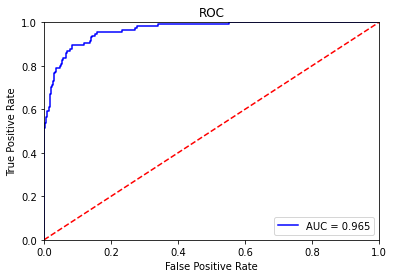

In [ ]:
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_dev_tfidf)


# Evaluate the classifier
evaluate_nb(probs, y_dev)

predict test data.\
Kaggle: 0.57142

In [ ]:
# save predict to csv
test_pred = nb_model.predict(X_test_tfidf)
df = pd.DataFrame(test_pred)
df.to_csv("submission_baseline.csv", header=["Predicted"],index=True) 

# Deep learning Model

Before loading dataset to program, we need a Configuration which helps us to modify the parameters like max_length or tokenizer types...

In [ ]:
import numpy as np
import torch.nn as nn
from transformers import AutoConfig


class Config(object):
    """Config Parameters"""

    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # set device
        # self.require_improvement = 100  # if nothing imporved when reached 100 epoch, end the proram
        self.num_classes = 2  
        self.pad_size = 400 # max length
        self.hidden_size = 768  # models hidden size, 768 is the size of most pretrained model
        self.rnn_hidden = 768  # used for rnn model
        self.num_layers = 2  # used for rnn model
        self.MODEL = 'roberta_pretrained' # pretrained model
        self.out_hidden = AutoConfig.from_pretrained(self.MODEL, output_hidden_states=False) # config pretrained model to output hidden layers
        self.dropout = 0.1

        # config about training
        self.num_epochs = 30
        self.batch_size = 25 
        self.learning_rate = 5e-5
        self.criterion = nn.CrossEntropyLoss()#nn.BCEWithLogitsLoss()  # nn.MSELoss()


np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
config = Config()


Loading Data to program.

In [ ]:
from transformers import AutoTokenizer

# get the tokenizer
tokenizer = AutoTokenizer.from_pretrained(config.MODEL)

train_set = TweetDataset(tokenizer=tokenizer, maxlen=config.pad_size, data_type="train") 
dev_set = TweetDataset(tokenizer=tokenizer, maxlen=config.pad_size, data_type="dev") 
test_set = TweetDataset(tokenizer=tokenizer, maxlen=config.pad_size, data_type="test",label=False)
covid_set = TweetDataset(tokenizer=tokenizer, maxlen=config.pad_size, data_type="covid",label=False)

print("Done for preprocssing")

Done for preprocssing


# Create Model
1. Bert + FC

        Dev acc: 0.9384, f1: 0.8543
        Kaggle f1: 0.82105

In [ ]:
from transformers import AutoModel


class BASE_MODEL((nn.Module)):
    def __init__(self, config):
        super(BASE_MODEL, self).__init__()
        self.roberta = AutoModel.from_pretrained(config.MODEL)
        self.fc = nn.Linear(config.rnn_hidden, config.num_classes)

    def forward(self, seq, attn_mask):
        features = self.roberta(seq, attention_mask=attn_mask)  # seq, attn_mask
        out = self.fc(features.last_hidden_state[:,0])
        return out
    

2. Roberta + gru
        Dev acc: 0.9347014, f1:0.8568
        Kaggle f1: 0.8775

In [ ]:
class ROBETA_GRU_MODEL((nn.Module)):
    def __init__(self, config):
        super(ROBETA_GRU_MODEL, self).__init__()
        self.roberta = AutoModel.from_pretrained(config.MODEL)

        self.gru = nn.GRU(config.hidden_size, config.rnn_hidden, config.num_layers, batch_first=True,
                          dropout=config.dropout)

        self.fc_rnn = nn.Linear(config.rnn_hidden, config.num_classes)

    def forward(self, seq, attn_mask):
        features = self.roberta(seq, attention_mask=attn_mask)  # seq, attn_mask
        out, hn = self.gru(features.last_hidden_state)
        out = self.fc_rnn(hn[-1, :, :])
        return out


3. Robert + sentence + gru cell
        Dev acc: 0.94216, f1:0.8669
        Kaggle f1: 0.8599

In [ ]:
from transformers import AutoModel
import torch.nn.functional as F


class ROBETA_GRUCELL_MODEL((nn.Module)):
    def __init__(self, config):
        super(ROBETA_GRUCELL_MODEL, self).__init__()
        self.roberta = AutoModel.from_pretrained(config.MODEL)
        self.gru = nn.GRUCell(config.hidden_size, config.rnn_hidden)
        self.fc_rnn = nn.Linear(config.rnn_hidden, config.num_classes)
      

    def forward(self, seq, attn_mask):
        features = self.roberta(seq, attention_mask=attn_mask)  # seq, attn_mask
        last_state = features.last_hidden_state
        hiddens = []
        ids = seq.tolist()

        # go through all the batch
        for b in range(seq.size(0)):
            # ith batch, source tweet vector
            hidden = last_state[b, 0, :].view(1, -1)
            for i, j in enumerate(ids[b]):
                # sentence idx, token j
                if j == 2:
                    hidden = self.gru(last_state[b, i, :].view(1, -1), hidden)
            hiddens.append(hidden)
            
        logits = self.fc_rnn(torch.cat(hiddens, 0))
        
        return logits


4. Roberta + CNN
        Dev acc: 0.9439, f1:0.8623
        Kaggle f1: 0.83516

In [ ]:
from transformers import AutoConfig, AutoModel
import torch.nn.functional as F

class ROBETA_CNN_MODEL((nn.Module)):
    def __init__(self, config):
        super(ROBETA_GRU_MODEL, self).__init__()

        # set roberta to output hidden layers
        self.roberta = AutoModel.from_pretrained(config.MODEL,config=config.out_hidden)
        self.filter_sizes=[3, 4, 5]
        self.num_filters=[100, 100, 100]
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=config.hidden_size,
                      out_channels=self.num_filters[i],
                      kernel_size=self.filter_sizes[i])
            for i in range(len(self.filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(self.num_filters), config.num_classes)
        self.dropout = nn.Dropout(p=config.dropout)


    def forward(self, seq, attn_mask):

        # get the output and hidden layers
        features = self.roberta(seq, attention_mask=attn_mask)
        # change to (batch, embedding, max_length)
        last_hidden_reshape = features.last_hidden_state.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        conv_list = [F.relu(conv1d(last_hidden_reshape)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        pool_list = [F.max_pool1d(conv, kernel_size=conv.shape[2]) for conv in conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        fc = torch.cat([pool.squeeze(dim=2) for pool in pool_list], dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(fc))
        
        return logits



5. Sentence Pairing
          Dev Acc: 0.94578 F1: 0.8687
          Kaggle：0.89361


In [ ]:
from transformers import AutoConfig, AutoModel


class ROBETA_SPAIR_MODEL((nn.Module)):
    def __init__(self, config):
        super(ROBETA_SPAIR_MODEL, self).__init__()

        # set roberta to output hidden layers
        self.roberta = AutoModel.from_pretrained(config.MODEL,config=config.out_hidden)
        self.maxpool = nn.MaxPool1d(3, stride=2, padding=1)
        # catch each sentence pair
        # self.dropout = nn.Dropout(p=0.5)
        self.tanh = nn.Tanh()
        # self.linear = nn.Linear(config.hidden_size * 2, config.hidden_size)
        self.evidence = nn.Linear(config.hidden_size * 2, config.num_classes)



    def forward(self, seq, attn_mask):

        # get the output and hidden layers
        features = self.roberta(seq, attention_mask=attn_mask)
        
        logits = []
        input_ids = seq.tolist()

        # 8,256,768
        # go through every data in batch
        for b in range(seq.size(0)):

            # 256,768
            sen_vec_index = []
            # go through each token id in one data
            for i, j in enumerate(input_ids[b]):
                # 2 is </s> id
                if j == 2:
                    sen_vec_index.append(i)
          
            # num of tweets, 768
            # according index to extract sentence
            sen_vec = torch.index_select(features.last_hidden_state[b, :, :], 0, torch.Tensor(sen_vec_index).type_as(seq).long())
            # convert to 1 row 768 col,and repeat size time, become size * 768
            first_sen = sen_vec[0].view(1, -1).repeat(sen_vec.size(0), 1)

            # num of tweets, 768*2  
            pair = torch.cat([first_sen, sen_vec], 1)
            # num of tweets, 768
            logit = self.tanh(pair)
            
            # should be
            # logit = self.dropout(self.tanh(self.linear(pair)))

            # num of tweets,2
            logit = self.evidence(logit)
            # 2， 用mean是不确定有歧义的两个句子表现出来的值是什么样的
            logits.append(torch.mean(logit, 0))
        # 8,2
        logits = torch.stack(logits, 0)
        # logits = torch.nn.functional.softmax(logits)
        return logits

Use built model, and set optimizer for training.

In [ ]:
import torch.optim as optim

model = ROBETA_GRUCELL_MODEL(config)
model.to(config.device)

# set dynamic learning rate and L2, help to fit the training set but avoid overfitting
opti = optim.Adam(model.parameters(), lr = config.learning_rate, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(opti, step_size=15, gamma=0.5)

Some weights of the model checkpoint at roberta_pretrained were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta_pretrained and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Create batch data use dataloader.

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=config.batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=config.batch_size)
covid_loader = DataLoader(covid_set, batch_size=config.batch_size)
print("Data Loaded.")

Data Loaded.


# Train Model
Create evaluate function for bp, it contains accuracy, precision, recall and f1.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support


def get_accuracy_from_logits(logits, labels):
    # print("logits: ", logits)
    # use sigmoid to do binary cls
    probs = torch.argmax(logits.squeeze(), dim=1)
    print("predict: ",probs)
    print("labels: ",labels)
    acc = (probs.squeeze() == labels).float().mean()
    return acc


def evaluate(net, dataloader, ep):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0
    predicted = []
    true_label = []
    with torch.no_grad():
        for seq, attn_masks, labels in dataloader:
            
            # caculate the accuracy and loss for every batch
            seq, attn_masks, labels = seq.to(config.device), attn_masks.to(config.device), labels.to(config.device)
            logits = net(seq.squeeze(1), attn_masks)
            mean_loss += nn.functional.cross_entropy(logits.squeeze(-1), labels.type(torch.LongTensor).to(config.device) , reduction='mean')
            mean_acc += get_accuracy_from_logits(logits, labels)
            count += 1

            # record every p r f1
            true_label.extend(labels.tolist())
            probs = torch.argmax(logits.squeeze(), dim=1)
            tmp = (probs.squeeze() == labels).float().tolist()
            predicted.extend(tmp)

        with dev_summary_writer.as_default():
            summary.scalar('loss', (mean_loss/count).data.cpu().numpy(), step=ep)
            summary.scalar('accuracy', (mean_acc/count).data.cpu().numpy(), step=ep)
            
    p, r, f, _ = precision_recall_fscore_support(true_label, predicted, pos_label=1, average="macro")
    return mean_acc / count, mean_loss / count, p, r, f


Train function

In [ ]:
import time


def train(net, criterion, opti, train_loader, dev_loader, max_eps, device):
    best_acc = 0
    st = time.time()
    # every epoch
    for ep in range(max_eps):

        net.train()
        # for it, batch_encoding in enumerate(train_loader2):
        for it, (seq, attn_masks, labels) in enumerate(train_loader):
            # Clear gradients
            opti.zero_grad()

            # Obtaining the logits from the model
            seq, attn_masks, labels = seq.to(config.device), attn_masks.to(config.device), labels.to(config.device)
            logits = net(seq.squeeze(1), attn_masks)

            # Computing loss
            loss = nn.functional.cross_entropy(logits.squeeze(-1), labels.type(torch.LongTensor).to(config.device))

            """
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in neta.parameters())
            loss = loss + l2_lambda * l2_norm
            """

            # Backpropagating the gradients
            loss.backward()

            opti.step()

            if it % 50 == 0:
                acc = get_accuracy_from_logits(logits, labels)
                print("{},{},{},{}; Time taken (s): {}".format(it, ep,loss.item(),acc, (time.time() - st)))
                st = time.time()

        scheduler.step()

        # show in tensorboard
        with train_summary_writer.as_default():
            summary.scalar('loss', loss.item(), step=ep)
            
        dev_acc, dev_loss, p, r, f = evaluate(net, dev_loader, ep)
        print("Epoch {} complete! Development Accuracy: {}; Development Loss: {}, Precision: {}, Recall: {}, F1: {}".format(ep, dev_acc, dev_loss,p, r, f))
        
        if dev_acc > best_acc:
            print("Best development accuracy improved from {} to {}, saving model...".format(best_acc, dev_acc))
            best_acc = dev_acc
            torch.save(net.state_dict(), 'evidence512_{}.pt'.format(ep))


Enable tensorboard

In [ ]:
from torchvision import transforms, utils, datasets
from tensorflow import summary
import datetime
%load_ext tensorboard

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/tensorboard/train/evidence512-' + current_time
dev_log_dir = 'logs/tensorboard/dev/evidence512-' + current_time
train_summary_writer = summary.create_file_writer(train_log_dir)
dev_summary_writer = summary.create_file_writer(dev_log_dir)

In [ ]:
%tensorboard --logdir logs/tensorboard

Train the model

In [ ]:
train(model, config.criterion, opti, train_loader, dev_loader, config.num_epochs,device=config.device)

# Prediction

In [ ]:
import numpy as np
import pandas as pd 
from tqdm import tqdm
def predict(net, dataloader):
    """
    Use fine tuned bert to predict (forward)
    """
    net.eval()

    logits = []
    with torch.no_grad():
        # go through each batch
        for seq, attn_masks in tqdm(dataloader):
            # compute logits
            seq, attn_masks = seq.to(config.device), attn_masks.to(config.device)
            logit = net(seq.squeeze(1),attn_masks)
            logits.append(logit)
            
    # concatenate batch
    logits = torch.cat(logits, dim=0)
    probs = torch.argmax(logits.squeeze(), dim=1)

    return probs.cpu().numpy()


In [ ]:
# load the best parameter
model_1_batch = ROBETA_GRU_MODEL(config)
model_1_batch.load_state_dict(torch.load("evidence512.pt"))
model_1_batch.to(config.device)

In [ ]:
predicts_test = predict(model_1_batch, test_loader)
pd.DataFrame(predicts_test).to_csv("submission18-eviden400-25.csv")

# predicts_covid = predict(model_1_batch, covid_loader)
# pd.DataFrame(predicts_covid).to_csv("covid_result_best.csv")


# Sentiment Analysis

Predict COVID

In [ ]:
predicts_covid = predict(model_1_batch, covid_loader)
pd.DataFrame(predicts_covid).to_csv("covid_result_best.csv")

  
covid_source = []
for i in covid_set:
  covid_source.append(i[0])

In [ ]:
rumour = []
for i,j in zip(covid_source,predicts_covid):
  if j == 1:
    rumour.append(i)
print(len(rumour))
nonrumour = []
for i,j in zip(covid_source,predicts_covid):
  if j == 0:
    nonrumour.append(i)
print(len(nonrumour))

In [ ]:
import nltk
import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
%matplotlib inline
import matplotlib.pyplot as plt


sentiment = SentimentIntensityAnalyzer()

# neg, neu, pos
rumour_sentiments = [0, 0, 0]
for r in rumour:
    scores = sentiment.polarity_scores(r)
    # neg
    if scores["neg"] > scores["pos"] and scores["neg"] > scores["neu"]:
        rumour_sentiments[0] += 1
    # pos
    elif scores["pos"] > scores["neg"] and scores["pos"] > scores["neu"]:
        rumour_sentiments[2] += 1
    # neu
    else:
        rumour_sentiments[1] += 1

nonrumour_sentiments = [0, 0, 0]
for n in nonrumour:
    scores = sentiment.polarity_scores(n)
    if scores["neg"] > scores["pos"] and scores["neg"] > scores["neu"]:
        nonrumour_sentiments[0] += 1
    elif scores["pos"] > scores["neg"] and scores["pos"] > scores["neu"]:
        nonrumour_sentiments[2] += 1
    else:
        nonrumour_sentiments[1] += 1


rumour_neu_percent = rumour_sentiments[1]/(rumour_sentiments[0]+rumour_sentiments[1]+rumour_sentiments[2])
rumour_neg_percent = rumour_sentiments[0]/(rumour_sentiments[0]+rumour_sentiments[2])
rumour_pos_percent = rumour_sentiments[2]/(rumour_sentiments[0]+rumour_sentiments[2])


nonrumour_neu_percent = nonrumour_sentiments[1]/(nonrumour_sentiments[0]+nonrumour_sentiments[1]+nonrumour_sentiments[2])
nonrumour_neg_percent = nonrumour_sentiments[0]/(nonrumour_sentiments[0]+nonrumour_sentiments[2])
nonrumour_pos_percent = nonrumour_sentiments[2]/(nonrumour_sentiments[0]+nonrumour_sentiments[2])

print(rumour_neu_percent,rumour_neg_percent,rumour_pos_percent)
print(nonrumour_neu_percent,nonrumour_neg_percent,nonrumour_pos_percent)